In [1]:
from nsimpkg.random_variables import BetaRV, LogitNormalRV
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from tqdm import tqdm
from nsimpkg.mcsim import rho
from nsimpkg.plotting import plot_iters_beta, plot_params_beta, plot_mse
from nsimpkg.beta_OAIS import Adam_OAIS_beta, AdaGrad_OAIS_beta
np.random.seed(0)

plt.rcParams["figure.dpi"] = 300
def phi(x):
    return (np.abs(x-0.5)<0.25).astype(float)
pi = LogitNormalRV(0, 1)
q0 = BetaRV(1, 1)
N = 1000
Niter = int(1e4)
alpha_adam = 1e-1
alpha_adagrad = 1e-2
nexperiments = 100
adam_experiment_distributions = []
adagrad_experiment_distributions = []
adam_experiment_results = []
adagrad_experiment_results = []
for experiment in range(nexperiments):
    adam_results, adam_distributions = Adam_OAIS_beta(phi, pi, q0, N, Niter, alpha=alpha_adam)
    adam_experiment_distributions.append(adam_distributions)
    adam_experiment_results.append(adam_results)

    adagrad_results, adagrad_distributions = AdaGrad_OAIS_beta(phi, pi, q0, N, Niter, alpha=alpha_adagrad)
    adagrad_experiment_distributions.append(adagrad_distributions)
    adagrad_experiment_results.append(adagrad_results)

100%|██████████| 10000/10000 [00:07<00:00, 1254.99it/s]


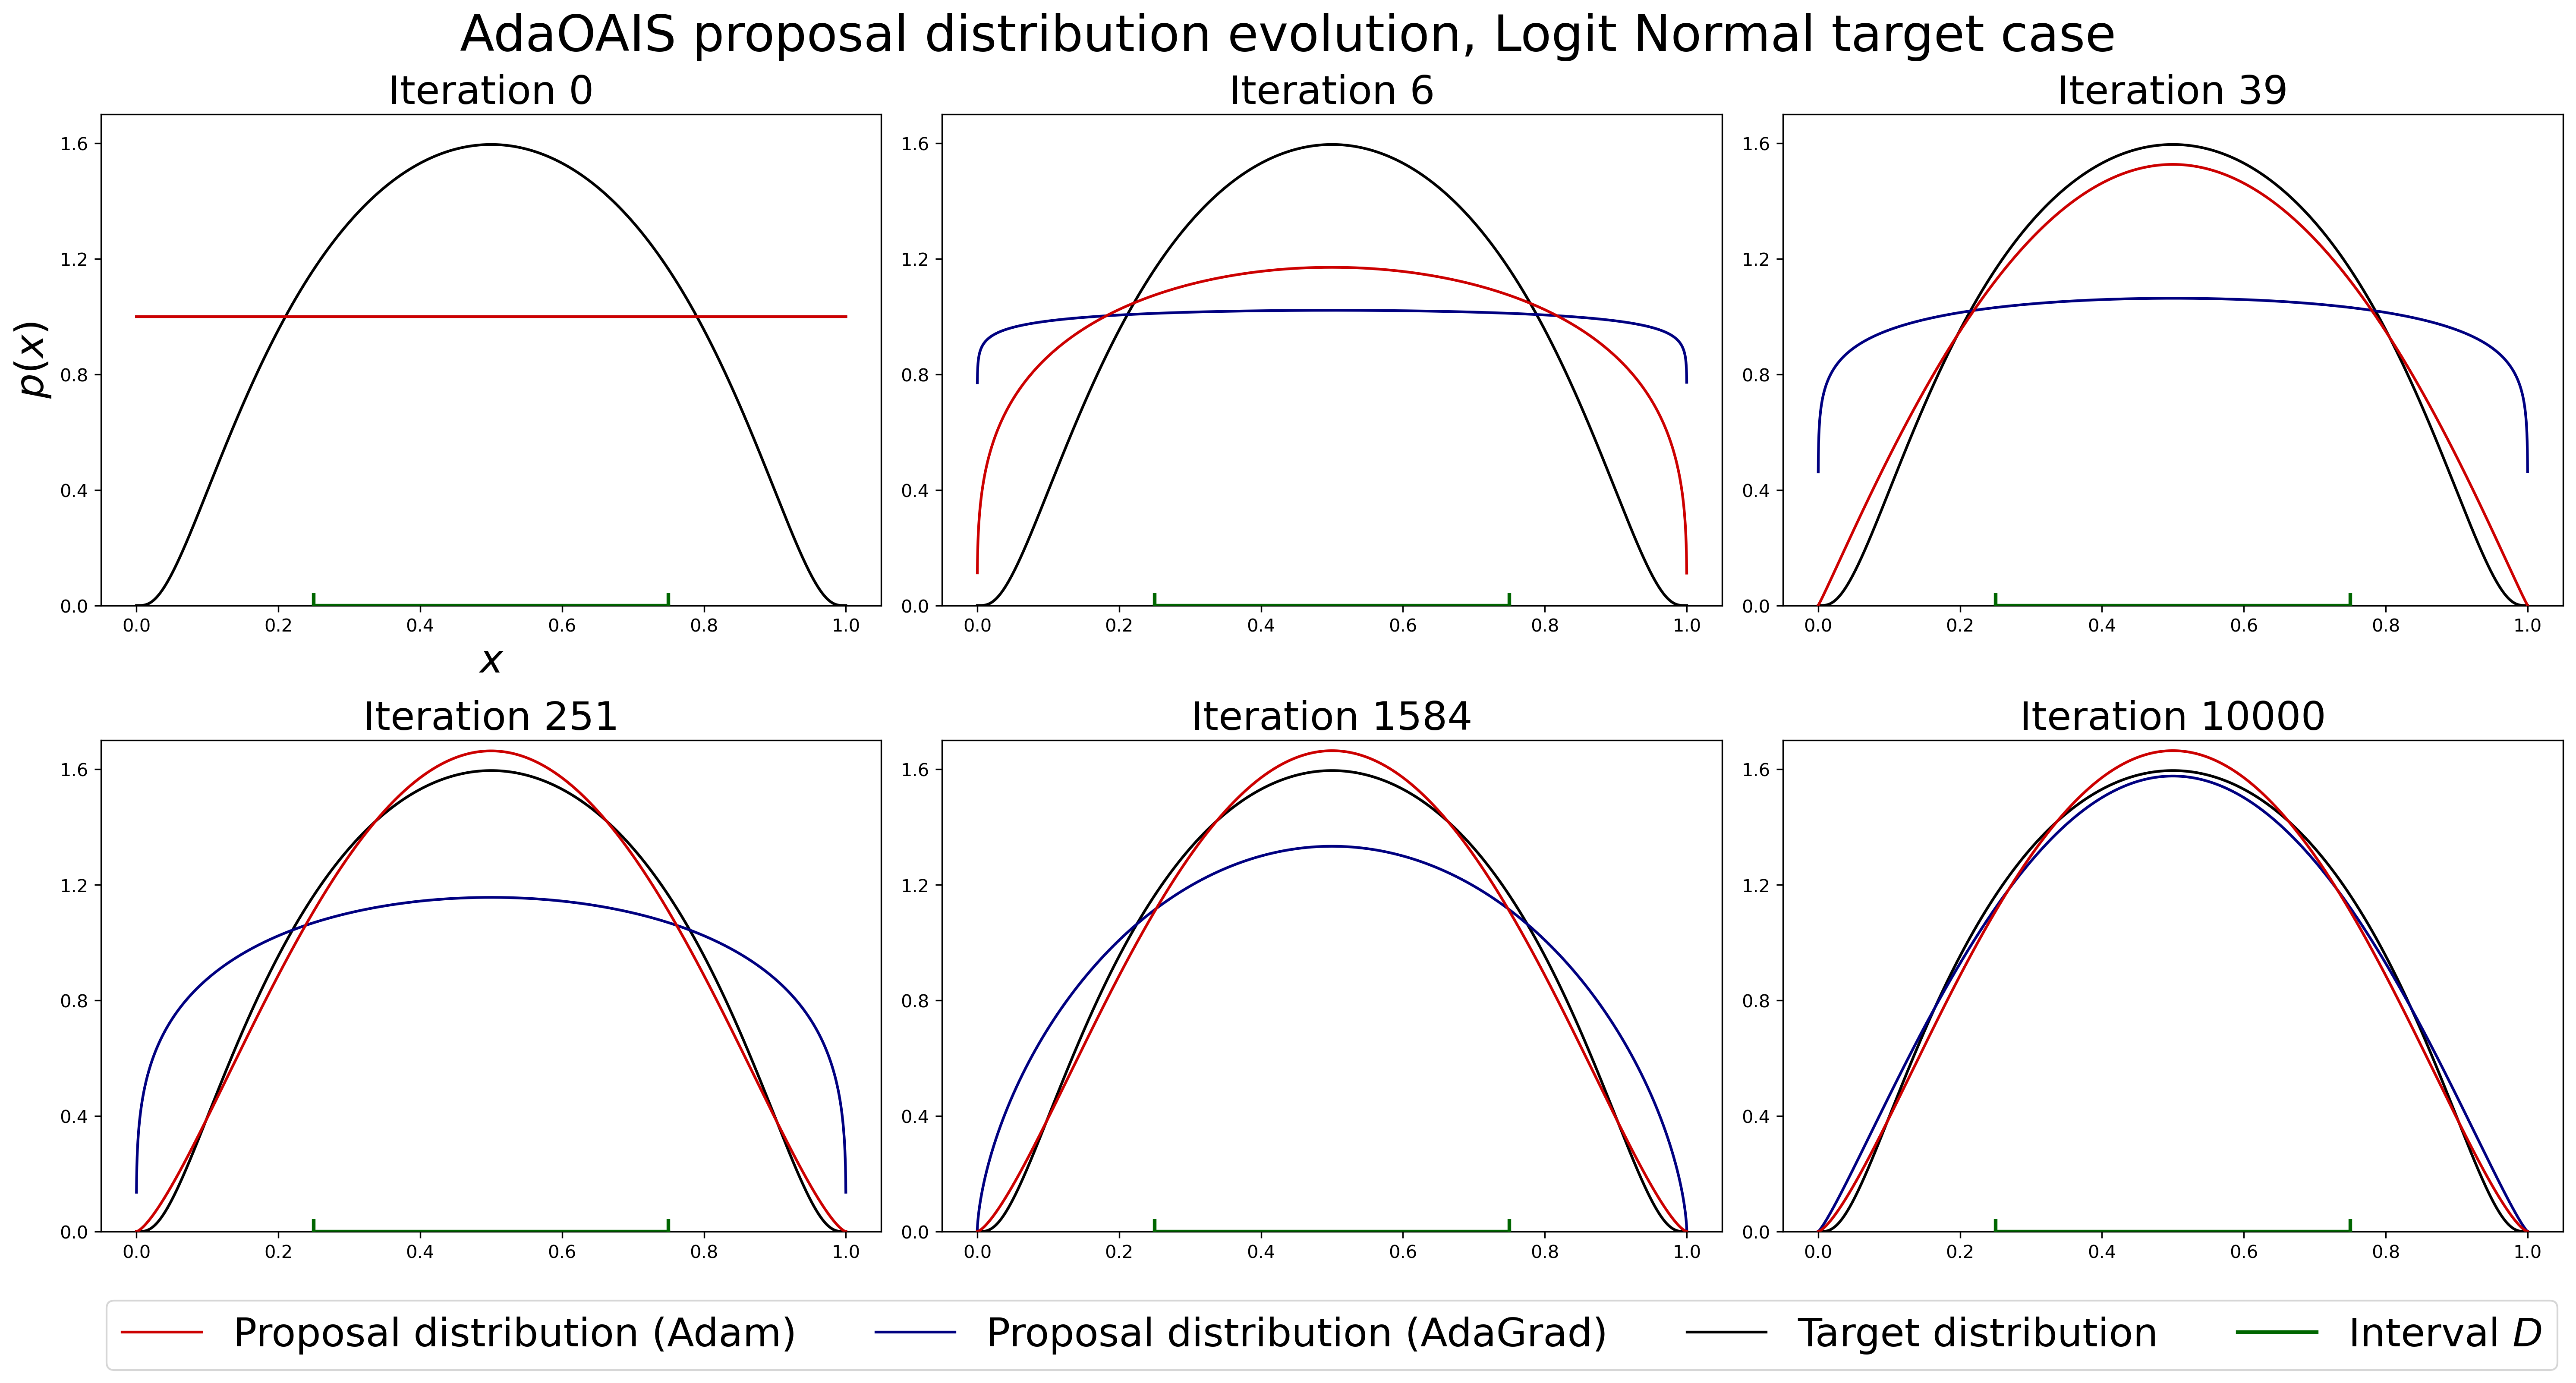

In [45]:
grid = np.linspace(0.0001, 0.9999, Niter)

alphas_adam =  np.array([np.array([dist.alpha for dist in experiment]) for experiment in adam_experiment_distributions])
betas_adam =  np.array([np.array([dist.beta for dist in experiment]) for experiment in adam_experiment_distributions])
alphas_adagrad =  np.array([np.array([dist.alpha for dist in experiment]) for experiment in adagrad_experiment_distributions])
betas_adagrad =  np.array([np.array([dist.beta for dist in experiment]) for experiment in adagrad_experiment_distributions])


average_alphas_adam = np.mean(alphas_adam, axis=0)
average_betas_adam = np.mean(betas_adam, axis=0)
average_alphas_adagrad = np.mean(alphas_adagrad, axis=0)
average_betas_adagrad = np.mean(betas_adagrad, axis=0)


fig, axs = plt.subplots(2, 3, figsize=(20, 10))
proposal_to_get = np.logspace(0, np.log10(Niter), 6, dtype=int)
proposal_to_get[proposal_to_get==1] = 0
for i, (ax, proposal) in enumerate(zip(axs.flatten(), proposal_to_get)):
    alpha_plot_adam = average_alphas_adam[proposal]
    beta_plot_adam = average_betas_adam[proposal]
    proposal_plot_adam = BetaRV(alpha_plot_adam, beta_plot_adam)
    proposal_plot_pdf_adam = proposal_plot_adam.pdf(grid)
    alpha_plot_adagrad = average_alphas_adagrad[proposal]
    beta_plot_adagrad = average_betas_adagrad[proposal]
    proposal_plot_adagrad = BetaRV(alpha_plot_adagrad, beta_plot_adagrad)
    proposal_plot_pdf_adagrad = proposal_plot_adagrad.pdf(grid)
    

    ax.plot(grid, proposal_plot_pdf_adam, color=[0.8, 0, 0], label="Proposal distribution (Adam)", zorder=10)
    ax.plot(grid, proposal_plot_pdf_adagrad, color=[0, 0, 0.5], label="Proposal distribution (AdaGrad)", zorder=9)
    
    ax.plot(grid, pi.pdf(grid), color="black", label="Target distribution")
    ax.set_title("Iteration {}".format(proposal), fontsize=22)
    ax.scatter([0.25, 0.75], [0,0], marker="|", color=[0, 0.4, 0], zorder=10000, linewidth=2, s=200)
    ax.plot([0.25, 0.75], [0,0], color=[0, 0.4, 0], zorder=1000, linewidth=2, label="Interval $D$")
    ax.set_ylim(0, 1.7)
    ax.set_yticks([0, 0.4, 0.8, 1.2, 1.6])
    if i== 0:
        ax.set_xlabel("$x$", fontsize=22)
        ax.set_ylabel("$p(x)$", fontsize=22)
fig.suptitle("AdaOAIS proposal distribution evolution, Logit Normal target case", fontsize=28)
plt.tight_layout()
axs[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4, fontsize=22)

In [ ]:
def plot_iters_beta(experiment_distributions, pi, title):
    Niter = len(experiment_distributions[0])
    grid = np.linspace(0.001, 0.999, Niter)
    alphas =  np.array([np.array([dist.alpha for dist in experiment]) for experiment in experiment_distributions])
    betas =  np.array([np.array([dist.beta for dist in experiment]) for experiment in experiment_distributions])
    average_alphas = np.mean(alphas, axis=0)
    average_betas = np.mean(betas, axis=0)
    fig, axs = plt.subplots(1, 6, figsize=(20, 4))
    proposal_to_get = np.logspace(0, np.log10(Niter), 6, dtype=int)
    proposal_to_get[proposal_to_get==1] = 0
    for i, proposal in enumerate(proposal_to_get):
        ax = axs[i]
        alpha_plot = average_alphas[proposal]
        beta_plot = average_betas[proposal]
        proposal_plot = BetaRV(alpha_plot, beta_plot)
        proposal_plot_pdf = proposal_plot.pdf(grid)
        ax.plot(grid, proposal_plot_pdf, color="red", label="Proposal distribution")
        ax.plot(grid, pi.pdf(grid), color="black", label="Target distribution")
        ax.set_title("Iteration {}".format(proposal), fontsize=14)
        ax.scatter([0.25, 0.75], [0,0], marker="|", color="blue", zorder=10000, linewidth=2)
        ax.plot([0.25, 0.75], [0,0], color="blue", zorder=1000, linewidth=2, label="Interval $D$")
        ax.set_ylim(0, 1.7)
        ax.set_yticks([0, 0.4, 0.8, 1.2, 1.6])
        if i== 0:
            ax.set_xlabel("$x$")
            ax.set_ylabel("$p(x)$")
            ax.legend(fontsize=6, loc="upper left")
    fig.suptitle(title, fontsize=20)
    plt.tight_layout()